In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
class MultiOutputVideoGenerator(keras.utils.Sequence):

    def __init__(self, df, video_dir, batch_size=4, num_frames=10, augment=False):
        self.df = df.reset_index(drop=True)
        self.video_dir = video_dir
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.augment = augment
        
        # Build video path cache
        self.video_path_cache = {}
        self.corrupted_videos = []
        self.successful_videos = 0
        self._build_path_cache()
    
    def _build_path_cache(self):
        """Cache video paths for faster lookup"""
        print(f"Building video path cache for {self.video_dir}...")
        
        if not os.path.exists(self.video_dir):
            print(f"Warning: Directory {self.video_dir} does not exist!")
            return
        
        for subject_folder in os.listdir(self.video_dir):
            subject_path = os.path.join(self.video_dir, subject_folder)
            
            if not os.path.isdir(subject_path):
                continue
            
            for video_folder in os.listdir(subject_path):
                video_folder_path = os.path.join(subject_path, video_folder)
                
                if not os.path.isdir(video_folder_path):
                    continue
                
                for file in os.listdir(video_folder_path):
                    if file.endswith('.avi') or file.endswith('.mp4'):
                        full_path = os.path.join(video_folder_path, file)
                        self.video_path_cache[file] = full_path
        
        print(f"Found {len(self.video_path_cache)} videos in cache")
    
    def find_video_path(self, clip_id):
        
        return self.video_path_cache.get(clip_id, None)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        
        batch_df = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]
        
        X = []
        y_dict = {
            'boredom': [],
            'engagement': [],
            'confusion': [],
            'frustration': [],
            'attention_score': []
        }
        
        for _, row in batch_df.iterrows():
            video_path = self.find_video_path(row['ClipID'])
            
            if video_path and os.path.exists(video_path):
                try:
                    frames = self.extract_frames_from_video(video_path, self.num_frames)
                    
                    if len(frames) == self.num_frames:
                        if self.augment:
                            frames = self._augment_frames(frames)
                        
                        X.append(frames)
                        
                        # Append labels for each emotion (0-3)
                        y_dict['boredom'].append(row['Boredom'])
                        y_dict['engagement'].append(row['Engagement'])
                        y_dict['confusion'].append(row['Confusion'])
                        y_dict['frustration'].append(row['Frustration'])
                        y_dict['attention_score'].append(row['attention_score'])
                        
                        self.successful_videos += 1
                except Exception as e:
                    if row['ClipID'] not in self.corrupted_videos:
                        self.corrupted_videos.append(row['ClipID'])
                    continue
        
        # Handle empty batches
        if len(X) == 0:
            X = np.zeros((1, self.num_frames, 224, 224, 3))
            for key in y_dict:
                y_dict[key] = np.zeros(1)
        else:
            X = np.array(X) / 255.0  # Normalize
            for key in y_dict:
                y_dict[key] = np.array(y_dict[key])
        
        return X, y_dict
    
    def extract_frames_from_video(self, video_path, num_frames=10):
        
        cap = None
        try:
            cap = cv2.VideoCapture(video_path)
            
            if not cap.isOpened():
                return np.array([])
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames < 1:
                cap.release()
                return np.array([])
            
            if total_frames < num_frames:
                num_frames = max(1, total_frames)
            
            frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
            frames = []
            failed_reads = 0
            max_failures = num_frames // 2
            
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                
                if ret and frame is not None:
                    try:
                        frame = cv2.resize(frame, (224, 224))
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(frame)
                        failed_reads = 0
                    except Exception:
                        failed_reads += 1
                        if len(frames) > 0:
                            frames.append(frames[-1])
                else:
                    failed_reads += 1
                    if failed_reads > max_failures:
                        break
                    if len(frames) > 0:
                        frames.append(frames[-1])
            
            cap.release()
            
            # Pad if needed
            while len(frames) < num_frames and len(frames) > 0:
                frames.append(frames[-1])
            
            if len(frames) < num_frames // 2:
                return np.array([])
            
            return np.array(frames[:num_frames])
            
        except Exception:
            if cap is not None:
                cap.release()
            return np.array([])
    
    def _augment_frames(self, frames):
        
        if np.random.random() > 0.5:
            frames = np.flip(frames, axis=2)
        
        brightness_factor = np.random.uniform(0.8, 1.2)
        frames = np.clip(frames * brightness_factor, 0, 255)
        
        contrast_factor = np.random.uniform(0.8, 1.2)
        mean = frames.mean()
        frames = np.clip((frames - mean) * contrast_factor + mean, 0, 255)
        
        return frames

print("✓ Multi-output data generator defined")


✓ Multi-output data generator defined


In [6]:
# Load labels
train_df = pd.read_csv('/Users/stevennn/Downloads/DAiSEE/Labels/TrainLabels.csv')
val_df = pd.read_csv('/Users/stevennn/Downloads/DAiSEE/Labels/ValidationLabels.csv')
test_df = pd.read_csv('/Users/stevennn/Downloads/DAiSEE/Labels/TestLabels.csv')

# Fix column names (remove trailing spaces)
train_df.columns = train_df.columns.str.strip()
val_df.columns = val_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Create attention score (0-1 range)
def create_attention_score(df):
    df['attention_score'] = (
        (df['Engagement'] * 0.5 - df['Boredom'] * 0.3 - 
         df['Confusion'] * 0.1 - df['Frustration'] * 0.1) + 3
    ) / 6  # Normalize to 0-1
    return df

train_df = create_attention_score(train_df)
val_df = create_attention_score(val_df)
test_df = create_attention_score(test_df)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\nLabel distribution in training set:")
for col in ['Boredom', 'Engagement', 'Confusion', 'Frustration']:
    print(f"\n{col}:")
    print(train_df[col].value_counts().sort_index())


Training samples: 5358
Validation samples: 1429
Test samples: 1784

Label distribution in training set:

Boredom:
Boredom
0    2433
1    1696
2    1073
3     156
Name: count, dtype: int64

Engagement:
Engagement
0      34
1     213
2    2617
3    2494
Name: count, dtype: int64

Confusion:
Confusion
0    3616
1    1245
2     431
3      66
Name: count, dtype: int64

Frustration:
Frustration
0    4183
1     941
2     191
3      43
Name: count, dtype: int64


In [7]:
import os
import cv2

DATASET_BASE = '/Users/stevennn/Downloads/DAiSEE/DataSet'  

# Create generators
train_gen = MultiOutputVideoGenerator(
    train_df,
    video_dir=os.path.join(DATASET_BASE, 'Train'),
    batch_size=4,
    num_frames=10,
    augment=True
)

val_gen = MultiOutputVideoGenerator(
    val_df,
    video_dir=os.path.join(DATASET_BASE, 'Validation'),
    batch_size=4,
    num_frames=10,
    augment=False
)

print("\n✓ Generators created successfully")
print(f"Training batches: {len(train_gen)}")
print(f"Validation batches: {len(val_gen)}")


Building video path cache for /Users/stevennn/Downloads/DAiSEE/DataSet/Train...
Found 5482 videos in cache
Building video path cache for /Users/stevennn/Downloads/DAiSEE/DataSet/Validation...
Found 1720 videos in cache

✓ Generators created successfully
Training batches: 1340
Validation batches: 358


In [8]:
def build_multi_output_model(input_shape=(10, 224, 224, 3)):

    
    # Input layer
    inputs = layers.Input(shape=input_shape, name='video_input')
    
    # ========================================
    # SPATIAL FEATURE EXTRACTION (CNN)
    # ========================================
    # Process each frame independently using TimeDistributed
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    
   
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    
    # TEMPORAL MODELING (LSTM)
    # Capture temporal patterns across frames
    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)
    
    # SHARED DENSE LAYERS

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # TASK-SPECIFIC OUTPUT HEADS

    # Each emotion has its own output layer (4 classes: 0, 1, 2, 3)
    boredom_output = layers.Dense(4, activation='softmax', name='boredom')(x)
    engagement_output = layers.Dense(4, activation='softmax', name='engagement')(x)
    confusion_output = layers.Dense(4, activation='softmax', name='confusion')(x)
    frustration_output = layers.Dense(4, activation='softmax', name='frustration')(x)
    
    # Continuous attention score (0-1)
    attention_score_output = layers.Dense(1, activation='sigmoid', name='attention_score')(x)
    
    model = models.Model(
        inputs=inputs,
        outputs=[
            boredom_output,
            engagement_output,
            confusion_output,
            frustration_output,
            attention_score_output
        ]
    )
    
    return model

# Building the model
model_multi = build_multi_output_model()

print("✓ Multi-output model created")
model_multi.summary()


2025-10-23 06:51:35.595642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-10-23 06:51:35.595662: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-10-23 06:51:35.595665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-10-23 06:51:35.595689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-23 06:51:35.595702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✓ Multi-output model created
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 video_input (InputLayer)    [(None, 10, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 10, 224, 224, 32)     896       ['video_input[0][0]']         
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 10, 112, 112, 32)     0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                 

In [9]:
# Calculating class weights to handle imbalance
def calculate_class_weights(df, column):
    """Calculate weights for imbalanced classes"""
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(df[column])
    weights = compute_class_weight('balanced', classes=classes, y=df[column])
    return dict(zip(classes, weights))

# Get class weights for each emotion
boredom_weights = calculate_class_weights(train_df, 'Boredom')
engagement_weights = calculate_class_weights(train_df, 'Engagement')
confusion_weights = calculate_class_weights(train_df, 'Confusion')
frustration_weights = calculate_class_weights(train_df, 'Frustration')

print("Class weights calculated:")
print(f"Boredom: {boredom_weights}")
print(f"Engagement: {engagement_weights}")
print(f"Confusion: {confusion_weights}")
print(f"Frustration: {frustration_weights}")


model_multi.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),  
    loss={
        'boredom': 'sparse_categorical_crossentropy',
        'engagement': 'sparse_categorical_crossentropy',
        'confusion': 'sparse_categorical_crossentropy',
        'frustration': 'sparse_categorical_crossentropy',
        'attention_score': 'mse'  
    },
    loss_weights={
        'boredom': 0.25,
        'engagement': 0.25,
        'confusion': 0.25,
        'frustration': 0.25,
        'attention_score': 1.0  
    },
    metrics={
        'boredom': ['accuracy'],
        'engagement': ['accuracy'],
        'confusion': ['accuracy'],
        'frustration': ['accuracy'],
        'attention_score': ['mae'] 
    }
)

print("\n✓ Model compiled successfully with legacy Adam optimizer")

Class weights calculated:
Boredom: {0: 0.5505548705302096, 1: 0.7897995283018868, 2: 1.2483690587138863, 3: 8.586538461538462}
Engagement: {0: 39.39705882352941, 1: 6.288732394366197, 2: 0.5118456247611769, 3: 0.5370890136327185}
Confusion: {0: 0.3704369469026549, 1: 1.0759036144578313, 2: 3.1078886310904874, 3: 20.295454545454547}
Frustration: {0: 0.3202247191011236, 1: 1.4234856535600424, 2: 7.013089005235602, 3: 31.151162790697676}

✓ Model compiled successfully with legacy Adam optimizer


In [14]:
import os

# Create directory if it doesn't exist
os.makedirs('saved_models/1', exist_ok=True)

callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when stuck
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),
    
    # Save best model 
    keras.callbacks.ModelCheckpoint(
        'saved_models/1/model.h5', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
  
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]
print("✓ Callbacks configured")

✓ Callbacks configured


In [15]:
# Train
history = model_multi.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

Epoch 1/30
1099/1340 [=======================>......] - ETA: 34s - loss: 1.0059 - boredom_loss: 1.2833 - engagement_loss: 0.9953 - confusion_loss: 0.9677 - frustration_loss: 0.7301 - attention_score_loss: 0.0118 - boredom_accuracy: 0.3926 - engagement_accuracy: 0.4788 - confusion_accuracy: 0.6359 - frustration_accuracy: 0.7663 - attention_score_mae: 0.0868

[mpeg4 @ 0x372fdd3c0] I cbpy damaged at 16 8
[mpeg4 @ 0x372fdd3c0] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 1.0122 - boredom_loss: 1.2937 - engagement_loss: 0.9867 - confusion_loss: 0.9748 - frustration_loss: 0.7460 - attention_score_loss: 0.0119 - boredom_accuracy: 0.3862 - engagement_accuracy: 0.4839 - confusion_accuracy: 0.6333 - frustration_accuracy: 0.7568 - attention_score_mae: 0.0873
Epoch 1: val_loss improved from inf to 1.26213, saving model to saved_models/1/model.h5


/opt/anaconda3/envs/tensorflow-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1340/1340 [==============================] - 231s 172ms/step - loss: 1.0122 - boredom_loss: 1.2937 - engagement_loss: 0.9867 - confusion_loss: 0.9748 - frustration_loss: 0.7460 - attention_score_loss: 0.0119 - boredom_accuracy: 0.3862 - engagement_accuracy: 0.4839 - confusion_accuracy: 0.6333 - frustration_accuracy: 0.7568 - attention_score_mae: 0.0873 - val_loss: 1.2621 - val_boredom_loss: 1.4741 - val_engagement_loss: 1.2359 - val_confusion_loss: 1.4081 - val_frustration_loss: 0.8439 - val_attention_score_loss: 0.0216 - val_boredom_accuracy: 0.2610 - val_engagement_accuracy: 0.3149 - val_confusion_accuracy: 0.2253 - val_frustration_accuracy: 0.7390 - val_attention_score_mae: 0.1218 - lr: 0.0010
Epoch 2/30
 123/1340 [=>............................] - ETA: 3:00 - loss: 1.0360 - boredom_loss: 1.2799 - engagement_loss: 1.0512 - confusion_loss: 1.0363 - frustration_loss: 0.7229 - attention_score_loss: 0.0135 - boredom_accuracy: 0.3898 - engagement_accuracy: 0.4327 - confusion_accuracy: 0.

[mpeg4 @ 0x13f658470] I cbpy damaged at 16 8
[mpeg4 @ 0x13f658470] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 1.0214 - boredom_loss: 1.3096 - engagement_loss: 0.9916 - confusion_loss: 0.9754 - frustration_loss: 0.7604 - attention_score_loss: 0.0121 - boredom_accuracy: 0.3848 - engagement_accuracy: 0.4849 - confusion_accuracy: 0.6280 - frustration_accuracy: 0.7514 - attention_score_mae: 0.0874
Epoch 2: val_loss improved from 1.26213 to 1.11950, saving model to saved_models/1/model.h5
1340/1340 [==============================] - 225s 168ms/step - loss: 1.0214 - boredom_loss: 1.3096 - engagement_loss: 0.9916 - confusion_loss: 0.9754 - frustration_loss: 0.7604 - attention_score_loss: 0.0121 - boredom_accuracy: 0.3848 - engagement_accuracy: 0.4849 - confusion_accuracy: 0.6280 - frustration_accuracy: 0.7514 - attention_score_mae: 0.0874 - val_loss: 1.1195 - val_boredom_loss: 1.3927 - val_engagement_loss: 1.0414 - val_confusion_loss: 1.1762 - val_frustration_loss: 0.7951 - val_attention_score_loss: 0.0181 - val_boredom_accuracy: 0.3303 - va

[mpeg4 @ 0x37548b7e0] I cbpy damaged at 16 8
[mpeg4 @ 0x37548b7e0] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 1.0726 - boredom_loss: 1.3748 - engagement_loss: 1.0540 - confusion_loss: 1.0185 - frustration_loss: 0.7868 - attention_score_loss: 0.0141 - boredom_accuracy: 0.3873 - engagement_accuracy: 0.4731 - confusion_accuracy: 0.6118 - frustration_accuracy: 0.7467 - attention_score_mae: 0.0945
Epoch 3: val_loss did not improve from 1.11950
1340/1340 [==============================] - 231s 172ms/step - loss: 1.0726 - boredom_loss: 1.3748 - engagement_loss: 1.0540 - confusion_loss: 1.0185 - frustration_loss: 0.7868 - attention_score_loss: 0.0141 - boredom_accuracy: 0.3873 - engagement_accuracy: 0.4731 - confusion_accuracy: 0.6118 - frustration_accuracy: 0.7467 - attention_score_mae: 0.0945 - val_loss: 1.2080 - val_boredom_loss: 1.4865 - val_engagement_loss: 1.1745 - val_confusion_loss: 1.3276 - val_frustration_loss: 0.7839 - val_attention_score_loss: 0.0149 - val_boredom_accuracy: 0.2897 - val_engagement_accuracy: 0.3149 - val_confusion

[mpeg4 @ 0x3754b3500] I cbpy damaged at 16 8
[mpeg4 @ 0x3754b3500] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 1.0972 - boredom_loss: 1.4051 - engagement_loss: 1.0722 - confusion_loss: 1.0378 - frustration_loss: 0.8130 - attention_score_loss: 0.0152 - boredom_accuracy: 0.3893 - engagement_accuracy: 0.4774 - confusion_accuracy: 0.6138 - frustration_accuracy: 0.7398 - attention_score_mae: 0.0977
Epoch 4: val_loss did not improve from 1.11950
1340/1340 [==============================] - 227s 169ms/step - loss: 1.0972 - boredom_loss: 1.4051 - engagement_loss: 1.0722 - confusion_loss: 1.0378 - frustration_loss: 0.8130 - attention_score_loss: 0.0152 - boredom_accuracy: 0.3893 - engagement_accuracy: 0.4774 - confusion_accuracy: 0.6138 - frustration_accuracy: 0.7398 - attention_score_mae: 0.0977 - val_loss: 1.2161 - val_boredom_loss: 1.4500 - val_engagement_loss: 1.1886 - val_confusion_loss: 1.2952 - val_frustration_loss: 0.8896 - val_attention_score_loss: 0.0103 - val_boredom_accuracy: 0.2680 - val_engagement_accuracy: 0.3191 - val_confusion

[mpeg4 @ 0x3754a89a0] I cbpy damaged at 16 8
[mpeg4 @ 0x3754a89a0] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 1.1185 - boredom_loss: 1.4249 - engagement_loss: 1.0619 - confusion_loss: 1.0806 - frustration_loss: 0.8455 - attention_score_loss: 0.0153 - boredom_accuracy: 0.3876 - engagement_accuracy: 0.4961 - confusion_accuracy: 0.6034 - frustration_accuracy: 0.7320 - attention_score_mae: 0.0986
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.11950
1340/1340 [==============================] - 225s 168ms/step - loss: 1.1185 - boredom_loss: 1.4249 - engagement_loss: 1.0619 - confusion_loss: 1.0806 - frustration_loss: 0.8455 - attention_score_loss: 0.0153 - boredom_accuracy: 0.3876 - engagement_accuracy: 0.4961 - confusion_accuracy: 0.6034 - frustration_accuracy: 0.7320 - attention_score_mae: 0.0986 - val_loss: 1.3409 - val_boredom_loss: 1.5981 - val_engagement_loss: 1.6319 - val_confusion_loss: 1.2847 - val_frustration_loss: 0.8101 - val_attention_score_loss: 0.0097 - v

[mpeg4 @ 0x3655dabc0] I cbpy damaged at 16 8
[mpeg4 @ 0x3655dabc0] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9991 - boredom_loss: 1.2803 - engagement_loss: 0.9767 - confusion_loss: 0.9505 - frustration_loss: 0.7443 - attention_score_loss: 0.0112 - boredom_accuracy: 0.3931 - engagement_accuracy: 0.4838 - confusion_accuracy: 0.6433 - frustration_accuracy: 0.7641 - attention_score_mae: 0.0848
Epoch 6: val_loss improved from 1.11950 to 1.11356, saving model to saved_models/1/model.h5
1340/1340 [==============================] - 223s 166ms/step - loss: 0.9991 - boredom_loss: 1.2803 - engagement_loss: 0.9767 - confusion_loss: 0.9505 - frustration_loss: 0.7443 - attention_score_loss: 0.0112 - boredom_accuracy: 0.3931 - engagement_accuracy: 0.4838 - confusion_accuracy: 0.6433 - frustration_accuracy: 0.7641 - attention_score_mae: 0.0848 - val_loss: 1.1136 - val_boredom_loss: 1.5069 - val_engagement_loss: 1.0427 - val_confusion_loss: 1.0288 - val_frustration_loss: 0.7791 - val_attention_score_loss: 0.0242 - val_boredom_accuracy: 0.2624 - va

[mpeg4 @ 0x36f536a60] I cbpy damaged at 16 8
[mpeg4 @ 0x36f536a60] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9901 - boredom_loss: 1.2606 - engagement_loss: 0.9724 - confusion_loss: 0.9605 - frustration_loss: 0.7239 - attention_score_loss: 0.0107 - boredom_accuracy: 0.4016 - engagement_accuracy: 0.4851 - confusion_accuracy: 0.6417 - frustration_accuracy: 0.7697 - attention_score_mae: 0.0827
Epoch 7: val_loss did not improve from 1.11356
1340/1340 [==============================] - 226s 168ms/step - loss: 0.9901 - boredom_loss: 1.2606 - engagement_loss: 0.9724 - confusion_loss: 0.9605 - frustration_loss: 0.7239 - attention_score_loss: 0.0107 - boredom_accuracy: 0.4016 - engagement_accuracy: 0.4851 - confusion_accuracy: 0.6417 - frustration_accuracy: 0.7697 - attention_score_mae: 0.0827 - val_loss: 1.1694 - val_boredom_loss: 1.6620 - val_engagement_loss: 1.0164 - val_confusion_loss: 1.1572 - val_frustration_loss: 0.7776 - val_attention_score_loss: 0.0161 - val_boredom_accuracy: 0.2645 - val_engagement_accuracy: 0.5654 - val_confusion

[mpeg4 @ 0x3636e9160] I cbpy damaged at 16 8
[mpeg4 @ 0x3636e9160] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9973 - boredom_loss: 1.2790 - engagement_loss: 0.9675 - confusion_loss: 0.9648 - frustration_loss: 0.7348 - attention_score_loss: 0.0108 - boredom_accuracy: 0.3973 - engagement_accuracy: 0.4858 - confusion_accuracy: 0.6374 - frustration_accuracy: 0.7648 - attention_score_mae: 0.0834
Epoch 8: val_loss did not improve from 1.11356
1340/1340 [==============================] - 227s 169ms/step - loss: 0.9973 - boredom_loss: 1.2790 - engagement_loss: 0.9675 - confusion_loss: 0.9648 - frustration_loss: 0.7348 - attention_score_loss: 0.0108 - boredom_accuracy: 0.3973 - engagement_accuracy: 0.4858 - confusion_accuracy: 0.6374 - frustration_accuracy: 0.7648 - attention_score_mae: 0.0834 - val_loss: 1.2481 - val_boredom_loss: 1.6845 - val_engagement_loss: 1.1779 - val_confusion_loss: 1.3148 - val_frustration_loss: 0.7776 - val_attention_score_loss: 0.0094 - val_boredom_accuracy: 0.3079 - val_engagement_accuracy: 0.3198 - val_confusion

[mpeg4 @ 0x104e69160] I cbpy damaged at 16 8
[mpeg4 @ 0x104e69160] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9860 - boredom_loss: 1.2661 - engagement_loss: 0.9515 - confusion_loss: 0.9481 - frustration_loss: 0.7357 - attention_score_loss: 0.0106 - boredom_accuracy: 0.4001 - engagement_accuracy: 0.4787 - confusion_accuracy: 0.6418 - frustration_accuracy: 0.7697 - attention_score_mae: 0.0827
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: val_loss did not improve from 1.11356
1340/1340 [==============================] - 220s 164ms/step - loss: 0.9860 - boredom_loss: 1.2661 - engagement_loss: 0.9515 - confusion_loss: 0.9481 - frustration_loss: 0.7357 - attention_score_loss: 0.0106 - boredom_accuracy: 0.4001 - engagement_accuracy: 0.4787 - confusion_accuracy: 0.6418 - frustration_accuracy: 0.7697 - attention_score_mae: 0.0827 - val_loss: 1.2071 - val_boredom_loss: 1.5721 - val_engagement_loss: 1.0990 - val_confusion_loss: 1.3228 - val_frustration_loss: 0.7695 - val_attention_score_loss: 0.0163 - v

[mpeg4 @ 0x104e73620] I cbpy damaged at 16 8
[mpeg4 @ 0x104e73620] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9406 - boredom_loss: 1.2139 - engagement_loss: 0.9093 - confusion_loss: 0.9075 - frustration_loss: 0.6944 - attention_score_loss: 0.0093 - boredom_accuracy: 0.4113 - engagement_accuracy: 0.5058 - confusion_accuracy: 0.6613 - frustration_accuracy: 0.7740 - attention_score_mae: 0.0778
Epoch 10: val_loss did not improve from 1.11356
1340/1340 [==============================] - 218s 162ms/step - loss: 0.9406 - boredom_loss: 1.2139 - engagement_loss: 0.9093 - confusion_loss: 0.9075 - frustration_loss: 0.6944 - attention_score_loss: 0.0093 - boredom_accuracy: 0.4113 - engagement_accuracy: 0.5058 - confusion_accuracy: 0.6613 - frustration_accuracy: 0.7740 - attention_score_mae: 0.0778 - val_loss: 1.1686 - val_boredom_loss: 1.5368 - val_engagement_loss: 1.0283 - val_confusion_loss: 1.2151 - val_frustration_loss: 0.7931 - val_attention_score_loss: 0.0253 - val_boredom_accuracy: 0.2960 - val_engagement_accuracy: 0.5675 - val_confusio

[mpeg4 @ 0x3636fedb0] I cbpy damaged at 16 8
[mpeg4 @ 0x3636fedb0] Error at MB: 344


1340/1340 [==============================] - ETA: 0s - loss: 0.9413 - boredom_loss: 1.2112 - engagement_loss: 0.9151 - confusion_loss: 0.8962 - frustration_loss: 0.7057 - attention_score_loss: 0.0092 - boredom_accuracy: 0.4171 - engagement_accuracy: 0.4948 - confusion_accuracy: 0.6613 - frustration_accuracy: 0.7760 - attention_score_mae: 0.0776Restoring model weights from the end of the best epoch: 6.

Epoch 11: val_loss did not improve from 1.11356
1340/1340 [==============================] - 222s 165ms/step - loss: 0.9413 - boredom_loss: 1.2112 - engagement_loss: 0.9151 - confusion_loss: 0.8962 - frustration_loss: 0.7057 - attention_score_loss: 0.0092 - boredom_accuracy: 0.4171 - engagement_accuracy: 0.4948 - confusion_accuracy: 0.6613 - frustration_accuracy: 0.7760 - attention_score_mae: 0.0776 - val_loss: 1.2031 - val_boredom_loss: 1.6695 - val_engagement_loss: 1.0299 - val_confusion_loss: 1.2804 - val_frustration_loss: 0.7830 - val_attention_score_loss: 0.0124 - val_boredom_accura

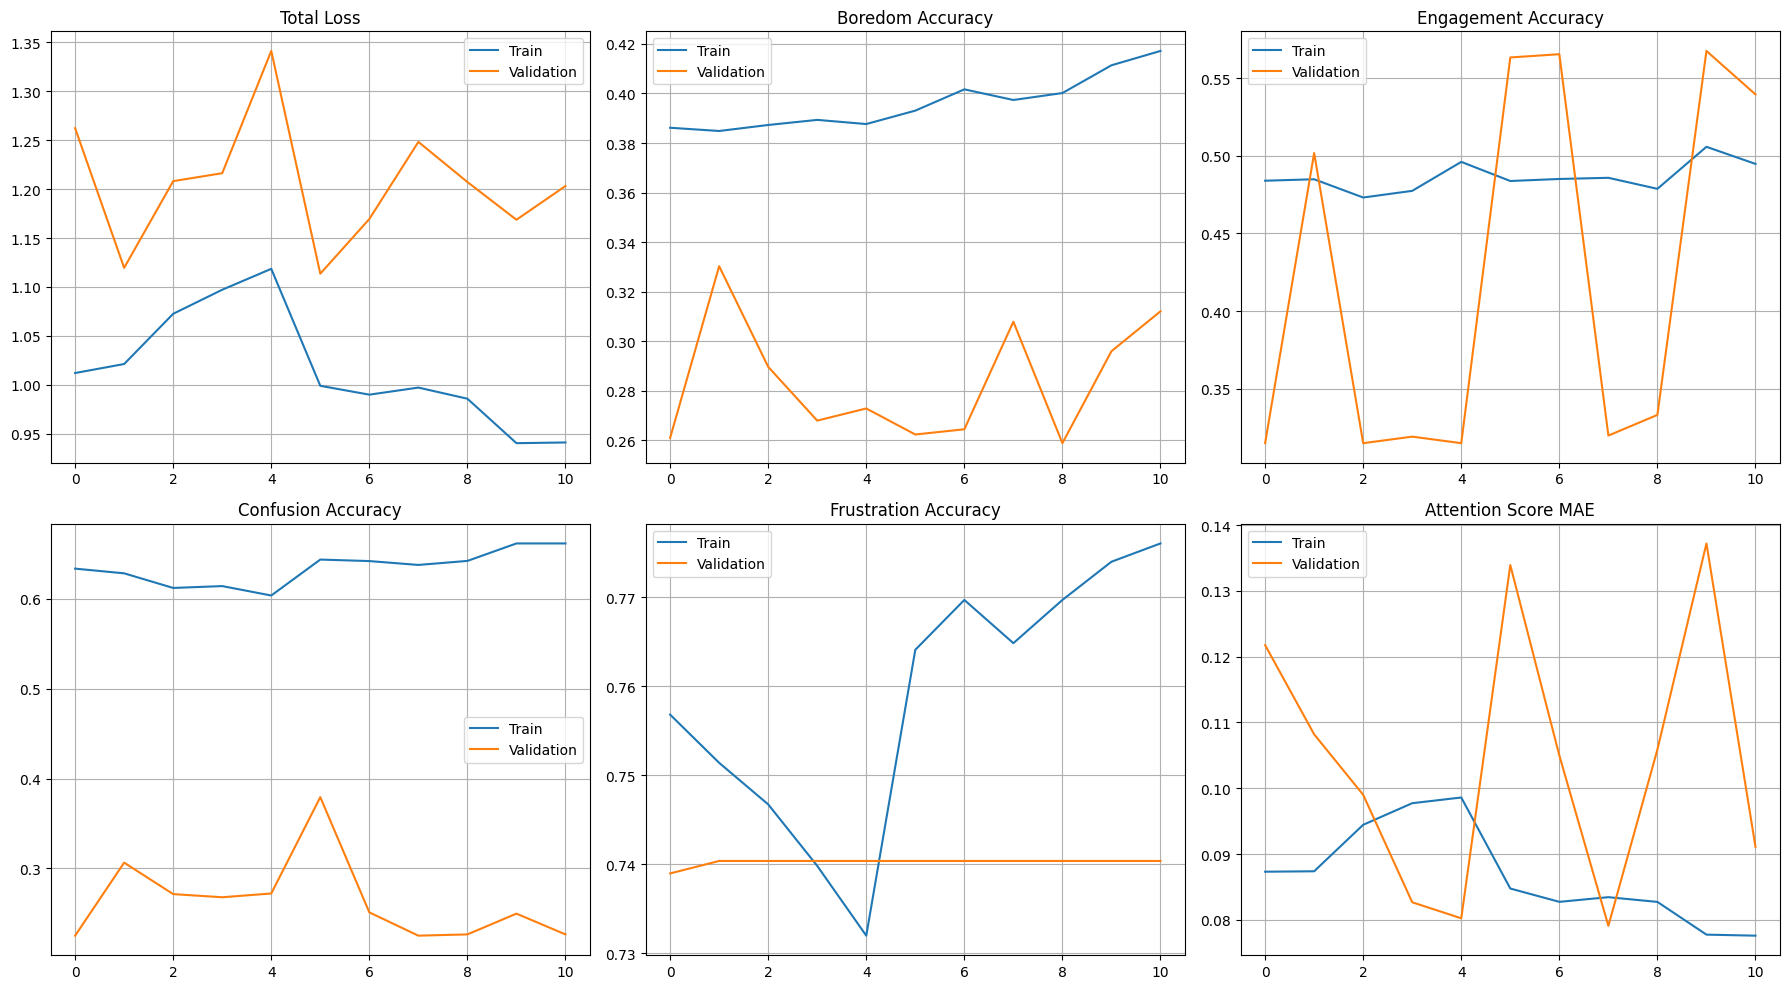

In [16]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss plots
axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Validation')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Boredom accuracy
axes[0, 1].plot(history.history['boredom_accuracy'], label='Train')
axes[0, 1].plot(history.history['val_boredom_accuracy'], label='Validation')
axes[0, 1].set_title('Boredom Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Engagement accuracy
axes[0, 2].plot(history.history['engagement_accuracy'], label='Train')
axes[0, 2].plot(history.history['val_engagement_accuracy'], label='Validation')
axes[0, 2].set_title('Engagement Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True)

# Confusion accuracy
axes[1, 0].plot(history.history['confusion_accuracy'], label='Train')
axes[1, 0].plot(history.history['val_confusion_accuracy'], label='Validation')
axes[1, 0].set_title('Confusion Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Frustration accuracy
axes[1, 1].plot(history.history['frustration_accuracy'], label='Train')
axes[1, 1].plot(history.history['val_frustration_accuracy'], label='Validation')
axes[1, 1].set_title('Frustration Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Attention score MAE
axes[1, 2].plot(history.history['attention_score_mae'], label='Train')
axes[1, 2].plot(history.history['val_attention_score_mae'], label='Validation')
axes[1, 2].set_title('Attention Score MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()
